In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from deeplabv3 import DeepLabV3

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [4]:
import torchvision.utils

In [5]:
from collections import defaultdict
import torch.nn.functional as F
import torch
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

In [7]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix

plt.ion()   # interactive mode

In [8]:
from PIL import Image
class Dataset(object):
    def __init__(self, datapath):
        # load paths for your dataset and put in self.data
        self.datapath = datapath
        self.maskpath = '../masks'
        self.data = []
        self.masks = []
        for folder in os.listdir(datapath):
            for filename in os.listdir(datapath+'/'+folder):
                self.data.append(folder+'/'+filename)
                self.masks.append(filename.split('.')[0])
            
            
    def __getitem__(self, idx):
        #img size: torch.randn(1, 3, 513, 513)
        
        # load images
        image = Image.open(self.datapath + '/' +  self.data[idx]).convert("RGB").resize((513,513))
        image_size = (image.size[0], image.size[1], 3)
        image = np.array(image.getdata()).reshape(image_size)
        maskname = self.maskpath + '/' +  self.masks[idx] + '_mask.jpg'
        
        mask_size = (65,65)

        if self.masks[idx] + '_mask.jpg' in os.listdir(self.maskpath):
            mask = np.array(Image.open(maskname).convert("RGB").resize(mask_size).getdata())
        elif self.masks[idx] + '_mask0.jpg' in os.listdir(self.maskpath):
            i = 0
            mask = np.zeros((mask_size[0],mask_size[1],3)).reshape([-1,3])
            while self.masks[idx] + '_mask' + str(i) + '.jpg' in os.listdir(self.maskpath):
                maskname = self.maskpath + '/' +  self.masks[idx] + '_mask' + str(i) + '.jpg'
                mask_ = np.array(Image.open(maskname).convert("RGB").resize(mask_size).getdata())
                mask = mask + mask_ # can add since masks should not overlap
                i += 1
        else:
            raise Exception("MISSING MASK!! for " + self.masks[idx])
            mask = np.zeros((mask_size[0],mask_size[1],3))

        mask = mask.reshape((mask_size[0],mask_size[1],3))
        mask = mask.mean(axis=2)
        #mask = mask.reshape([1,image_size[0], image_size[1]])
        
        mask = np.stack([mask,mask],axis=0)
        mask[1] = 255-mask[1]
        
        image = image.transpose([2,0,1])
        mask /= 255
        
        #two size options were reshaped to (672,672,3)
        #(1680, 1050, 3)
        #(640, 480, 3)
        #print('loaded: ' + self.data[idx])
        
        return torch.Tensor(image), torch.Tensor(mask)

    def __len__(self):
        return len(self.data)

In [9]:
data_dir = '../dataset'
image_datasets = {x: Dataset(os.path.join(data_dir, x))
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=3, 
                                             shuffle=True, num_workers=4, drop_last=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 2

model = DeepLabV3(
        n_classes=num_class,
        n_blocks=[3, 4, 23, 3],
        atrous_rates=[6, 12, 18],
        multi_grids=[1, 2, 4],
        output_stride=8,
    ).to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        

cuda:0


In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp /= 255
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def imshowimagemasked(img, mask, title=None):
    """Imshow for Tensor."""
    inp = img
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    #plt.imshow(inp)
    plt.imshow(mask.numpy()/255,cmap='jet',alpha=0.2)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def visualize_segmenter(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                imshow(inputs.cpu().data[j])
                imshowimagemasked(inputs.cpu().data[j], preds.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

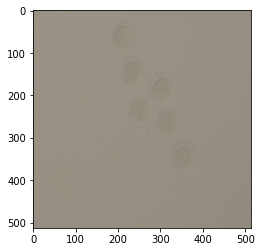

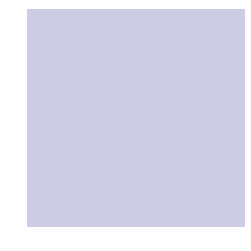

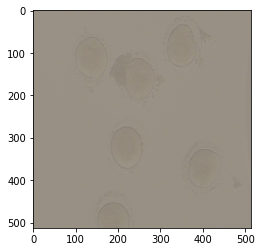

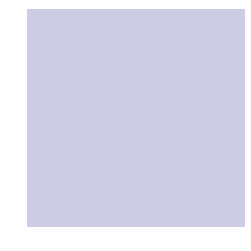

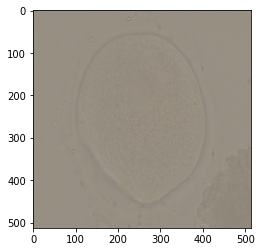

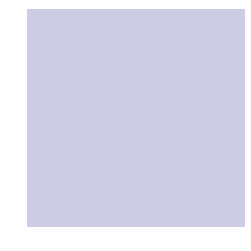

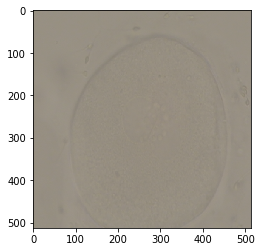

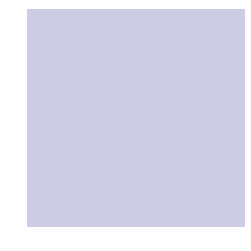

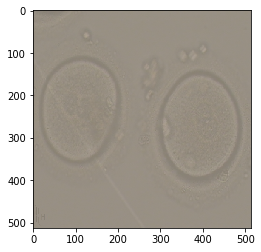

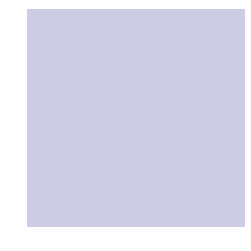

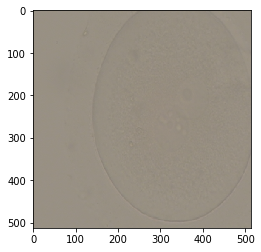

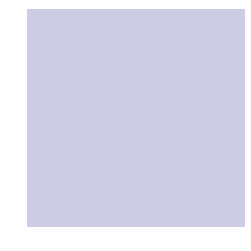

In [12]:
visualize_segmenter(model)

In [13]:
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
LR 0.0001
train: bce: 0.359435, dice: 0.342645, loss: 0.351040
val: bce: 0.262421, dice: 0.293980, loss: 0.278200
saving best model
11m 0s
Best val loss: 0.278200


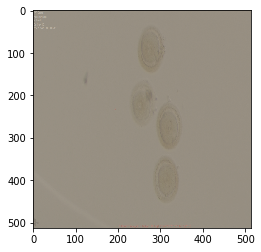

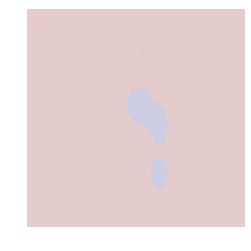

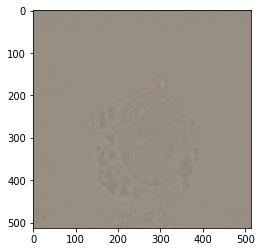

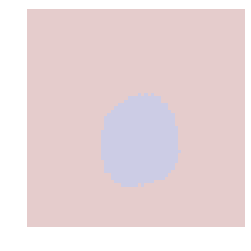

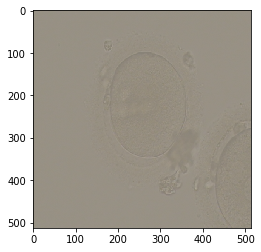

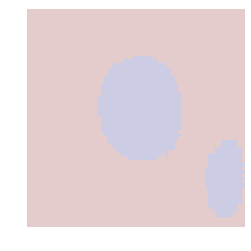

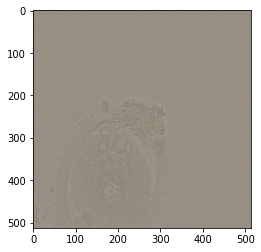

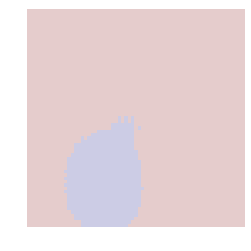

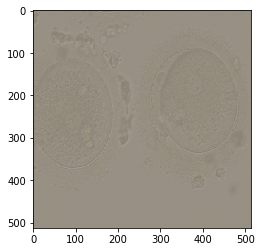

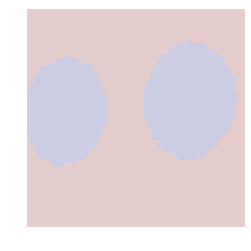

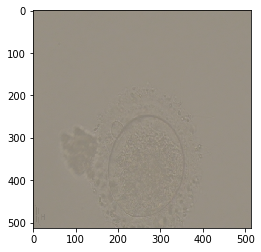

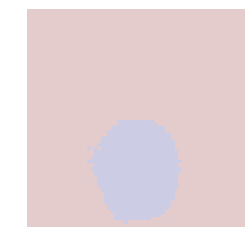

In [14]:
visualize_segmenter(model)

In [15]:
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------
LR 0.0001
train: bce: 0.210272, dice: 0.226741, loss: 0.218507
val: bce: 0.199679, dice: 0.218122, loss: 0.208901
saving best model
11m 5s
Epoch 1/5
----------
LR 0.0001
train: bce: 0.135747, dice: 0.153359, loss: 0.144553
val: bce: 0.124124, dice: 0.136685, loss: 0.130404
saving best model
11m 7s
Epoch 2/5
----------
LR 0.0001
train: bce: 0.104676, dice: 0.111867, loss: 0.108271
val: bce: 0.077669, dice: 0.082664, loss: 0.080166
saving best model
11m 6s
Epoch 3/5
----------
LR 0.0001
train: bce: 0.080909, dice: 0.085514, loss: 0.083211
val: bce: 0.087401, dice: 0.077809, loss: 0.082605
11m 7s
Epoch 4/5
----------
LR 0.0001
train: bce: 0.065751, dice: 0.067916, loss: 0.066833
val: bce: 0.108503, dice: 0.102784, loss: 0.105643
11m 1s
Epoch 5/5
----------
LR 0.0001


Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/opt/anaconda3/lib

KeyboardInterrupt: 

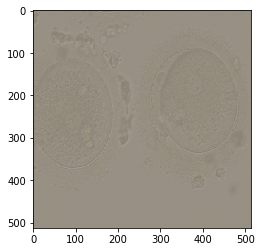

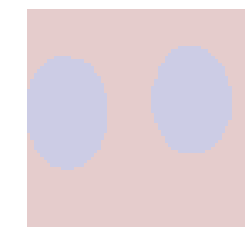

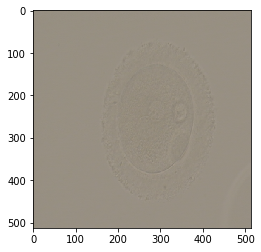

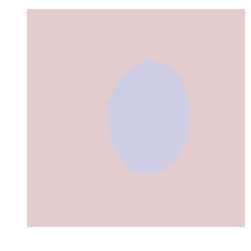

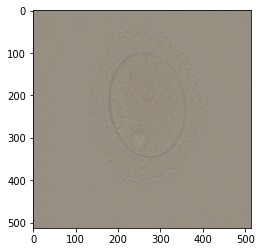

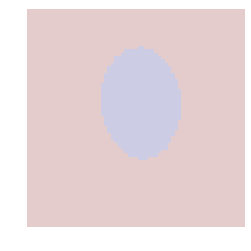

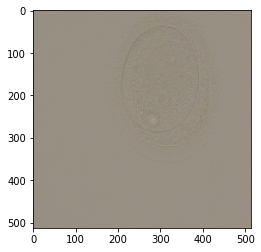

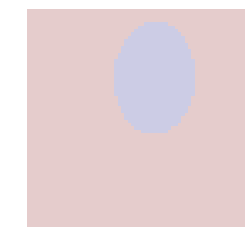

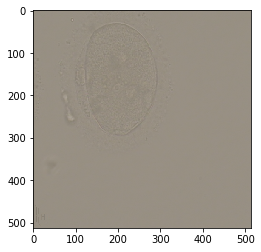

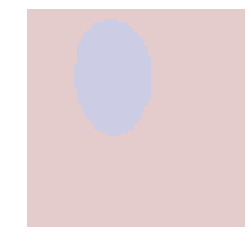

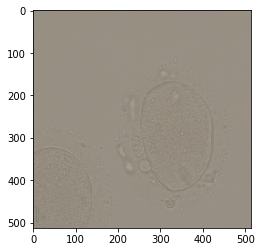

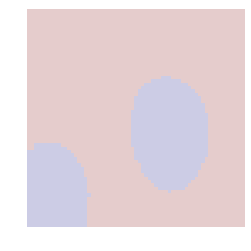

In [16]:
visualize_segmenter(model)

In [19]:
from scoring import iou_pytorch

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp /= 255
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def imshowimagemasked(img, mask, title=None):
    """Imshow for Tensor."""
    inp = img
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    #plt.imshow(inp)
    plt.imshow(mask.numpy()/255,cmap='jet',alpha=0.2)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def visualize_segmenter(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                imshow(inputs.cpu().data[j])
                imshowimagemasked(inputs.cpu().data[j], preds.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [33]:
from scoring import iou

In [39]:
def score_segmenter(model):
    was_training = model.training
    model.eval()
    running_score=0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            label_classes = torch.argmax(labels)
            running_score += iou(outputs, labels).mean() 
        running_score /= i
        model.train(mode=was_training)
    return running_score

In [40]:
results = score_segmenter(model)

In [41]:
print(results)

0.9137701815457838
